In [1]:
import numpy as np
import pandas as pd
from new_SPOC import *
import old_SPOC as old_SPOC
from generate_SPOC_model import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
n_nodes = 1000
n_clusters = 3
pnn = 10

Theta = generate_theta(n_nodes, n_clusters, pnn, seed=0)
B = np.diag([0.5, 0.5, 0.5])
P = Theta.dot(B).dot(Theta.T)
A = P_to_A(P, reflect=False, seed=0)

#### SPOC methods from A matrix

In [3]:
theta, b = old_SPOC.SPOC(A, n_clusters)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.132814685244
B relative error  0.285905276884


In [4]:
#### new_SPOC method without an ellipsoid transformation and without cvxpy opt in get_Theta ####

theta, b = SPOC(A, n_clusters, use_ellipsoid=False, use_cvxpy=False)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.132814685244
B relative error  0.285905276884


In [5]:
U, L = get_U_L(A, n_clusters)

theta, b, J = SPOC_from_UL(U, L, use_ellipsoid=True, use_cvxpy=False, return_pure_nodes_indices=True)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.132814685244
B relative error  0.285905276884


In [6]:
n_nodes = 500
n_clusters = 2
pure_nodes = 2
indices = np.arange(pure_nodes)
B = np.diag([0.2, 0.6])
seed=42

Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pure_nodes,\
                       pure_nodes_indices=indices, seed=seed)
P = Theta.dot(B).dot(Theta.T)
A = P_to_A(P, reflect=True, seed=0)

In [7]:
Theta = pd.DataFrame(Theta, columns=["cluster1", "cluster2"])

Theta["pure_node"] = Theta.cluster1.apply(lambda x: 1 if ((x == 1) or (x == 0)) else 0)
U, L =  get_U_L(A, k=2)

Theta["U_0"] = U[:,0]
Theta["U_1"] = U[:,1]

theta, b, J = SPOC_from_UL(U, L, use_ellipsoid=False, use_cvxpy=False, return_pure_nodes_indices=True)
Theta["SPOC pnn"] = 0
Theta.loc[J, "SPOC pnn"] = 1

theta, b, J, repeats = SPOC_bootstrap(A, 2, n_repetitions=500, regularization=0, return_pure_nodes_indices=True,\
                                      return_bootstrap_matrix=True)
Theta["bootstrap SPOC"] = 0
Theta.loc[J, "bootstrap SPOC"] = 1

usual_nodes = Theta[Theta["pure_node"] == 0]
SPOC_pn = Theta[Theta["SPOC pnn"] == 1]
pn = Theta[Theta["pure_node"] == 1]
bootstrap_SPOC = Theta[Theta["bootstrap SPOC"] == 1]

Theta.head(2)

,cluster1,cluster2,pure_node,U_0,U_1,SPOC pnn,bootstrap SPOC
0,1.0,0.0,1,0.012426,0.065205,0,0
1,0.0,1.0,1,0.072306,-0.025235,0,0


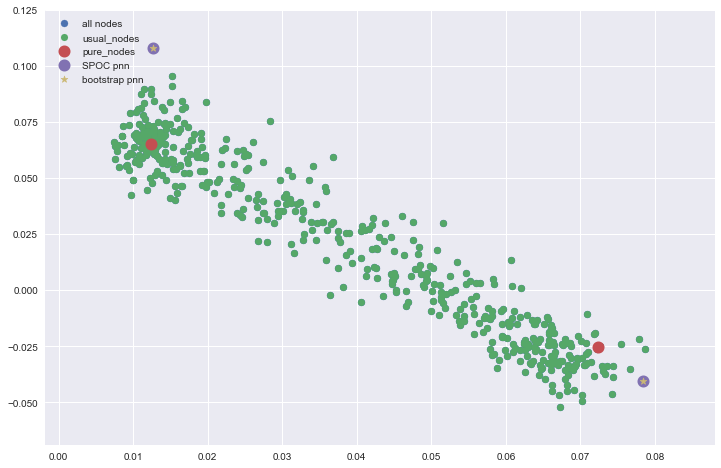

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(Theta.U_0, Theta.U_1, label="all nodes")
plt.scatter(usual_nodes.U_0, usual_nodes.U_1, label="usual_nodes", linewidths=0.1)
plt.scatter(pn.U_0, pn.U_1, label="pure_nodes", linewidths=5)
plt.scatter(SPOC_pn.U_0, SPOC_pn.U_1, label="SPOC pnn", linewidths=5)
plt.scatter(bootstrap_SPOC.U_0, bootstrap_SPOC.U_1, label="bootstrap pnn", marker='*', linewidths=0.6)
plt.legend(loc="upper left")
plt.grid(0.2)
plt.savefig("pnn_selection.png")

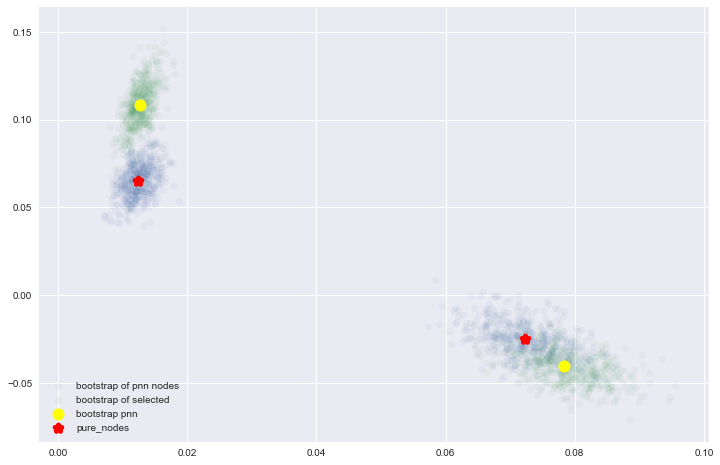

In [10]:
indices_pnn = pn.index
indices_bootstrap = bootstrap_SPOC.index

plt.figure(figsize=(12, 8))
plt.scatter(repeats[:, indices_pnn, 0], repeats[:, indices_pnn, 1], label="bootstrap of pnn nodes", \
           linewidths=0.1, alpha=0.05)
plt.scatter(repeats[:, indices_bootstrap, 0], repeats[:, indices_bootstrap, 1], \
            label="bootstrap of selected", linewidths=0.1, alpha=0.05)

plt.scatter(bootstrap_SPOC.U_0, bootstrap_SPOC.U_1, label="bootstrap pnn", c="yellow", linewidths=5)
plt.scatter(pn.U_0, pn.U_1, label="pure_nodes", linewidths=5, c="red", marker="*")

plt.legend(loc="lower left")
plt.grid(0.2)
plt.savefig("plot_bootstrap_nodes.png")

In [13]:
direct_std = []
for i in range(500):
    A = P_to_A(P, reflect=True, seed=i)
    U, L =  get_U_L(A, k=2)
    U = U[pn.index]
    direct_std.append(U)
direct_std = np.array(direct_std)

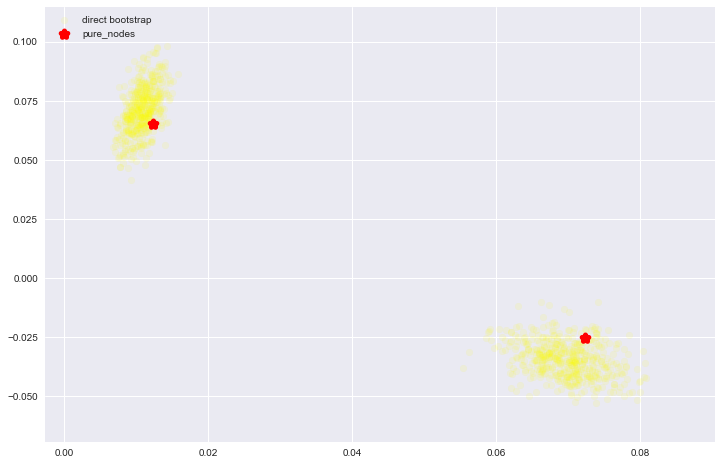

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(direct_std[:, pn.index, 0], direct_std[:, pn.index, 1], c="yellow", label = "direct bootstrap",\
           alpha=0.1, linewidths=0.1)
plt.scatter(pn.U_0, pn.U_1, label="pure_nodes", linewidths=5, c="r", marker="*")
plt.legend(loc="upper left")
plt.grid(0.2)